<a href="https://colab.research.google.com/github/IVarshaShetty/RecommendationEngine/blob/main/kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import re
!pip install surprise
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

In [ ]:
df1 = pd.read_csv('/content/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df1['Rating'] = df1['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df1.shape))
print('-Dataset examples-')
print(df1.iloc[::5000000, :])
df2 = pd.read_csv('/content/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df3 = pd.read_csv('/content/combined_data_3.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df4 = pd.read_csv('/content/combined_data_4.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

print('Dataset 2 shape: {}'.format(df2.shape))
print('Dataset 3 shape: {}'.format(df3.shape))
print('Dataset 4 shape: {}'.format(df4.shape))

<ipython-input-3-425067601739>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv('/content/combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


Dataset 1 shape: (1630721, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


<ipython-input-3-425067601739>:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv('/content/combined_data_2.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])


Dataset 2 shape: (1579772, 2)
Dataset 3 shape: (1681718, 2)
Dataset 4 shape: (1630658, 2)


In [ ]:
df = df1
#df = df1.append(df2)
#df = df.append(df3)
#df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (1630721, 2)
-Dataset examples-
  Cust_Id  Rating
0      1:     NaN


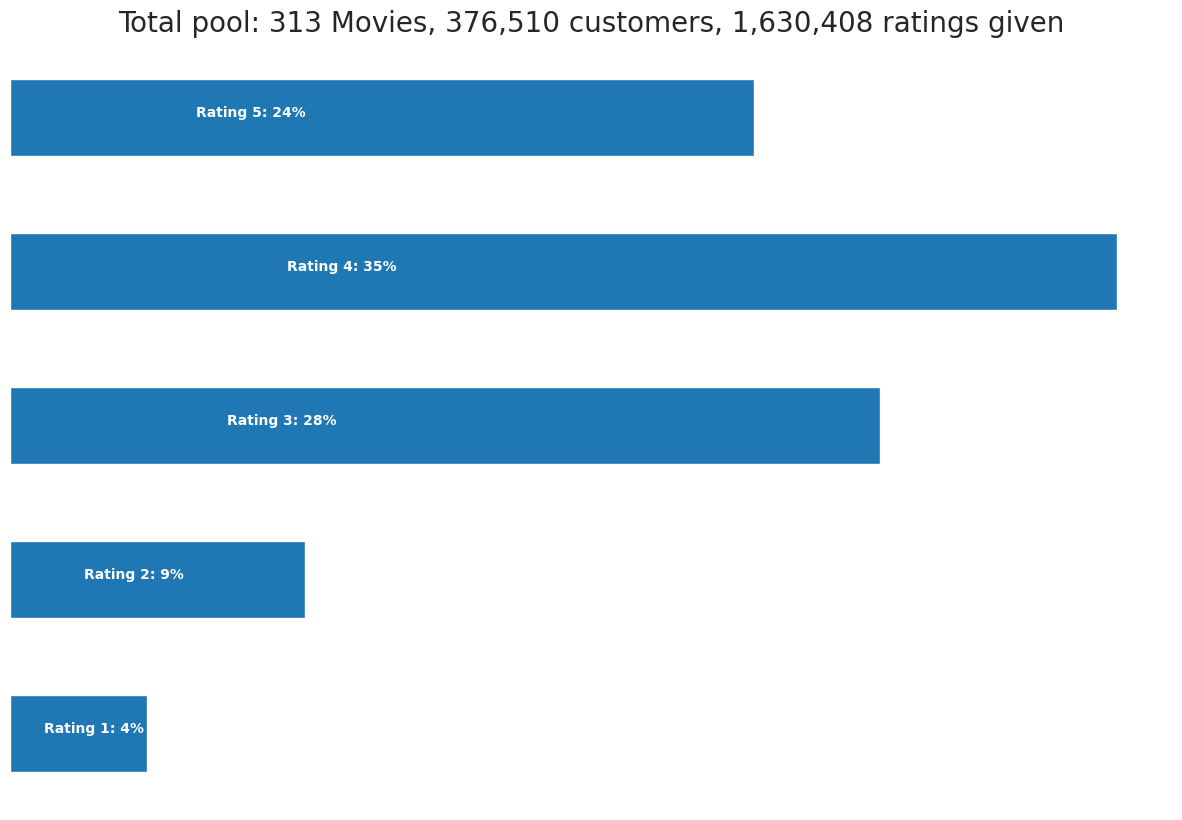

In [ ]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
movie_count = df.isnull().sum()[1]

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')
for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

In [ ]:
df_nan = pd.DataFrame(pd.isnull(df.Rating))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    # numpy approach
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1
last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [  1.   1.   1. ... 313. 313. 313.]
Length: 1630408


In [ ]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])

<ipython-input-7-6f95882c24ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Movie_Id'] = movie_np.astype(int)


-Dataset examples-
   Cust_Id  Rating  Movie_Id
1  1488844     3.0         1


<ipython-input-7-6f95882c24ee>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cust_Id'] = df['Cust_Id'].astype(int)


In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1885.0
Customer minimum times of review: 6.0


In [ ]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1885.0
Customer minimum times of review: 6.0


In [ ]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(324929, 313)


In [ ]:
df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


<ipython-input-12-d1f084f818ce>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_title = pd.read_csv('/content/movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'],error_bad_lines=False)
Skipping line 72: expected 3 fields, saw 4
Skipping line 264: expected 3 fields, saw 5
Skipping line 350: expected 3 fields, saw 4
Skipping line 366: expected 3 fields, saw 4
Skipping line 394: expected 3 fields, saw 4
Skipping line 466: expected 3 fields, saw 4
Skipping line 582: expected 3 fields, saw 4
Skipping line 600: expected 3 fields, saw 4
Skipping line 670: expected 3 fields, saw 4
Skipping line 672: expected 3 fields, saw 4
Skipping line 729: expected 3 fields, saw 4
Skipping line 776: expected 3 fields, saw 4
Skipping line 827: expected 3 fields, saw 4
Skipping line 834: expected 3 fields, saw 4
Skipping line 891: expected 3 fields, saw 4
Skipping line

In [ ]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:], reader)
#data.split(n_folds=3)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'])

{'test_rmse': array([0.98941845, 0.98563528, 0.98575074, 0.98661806, 0.98627595]),
 'test_mae': array([0.77754852, 0.77538241, 0.7746566 , 0.77582184, 0.77576434]),
 'fit_time': (27.396543979644775,
  28.728004932403564,
  28.531686782836914,
  29.163251638412476,
  29.03208017349243),
 'test_time': (4.263622045516968,
  3.9895753860473633,
  3.8200039863586426,
  3.4871926307678223,
  4.274468183517456)}

In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57        Richard III
175    Reservoir Dogs
311           Ed Wood
Name: Name, dtype: object


In [ ]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
57        Richard III
175    Reservoir Dogs
311           Ed Wood
Name: Name, dtype: object


In [ ]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [ ]:
recommend("What the #$*! Do We Know!?", 0)

For movie (What the #$*! Do We Know!?)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                       Name  count     mean
 1.000000                 What the #$*! Do We Know!?  14910 3.189805
 0.918559              Chained Heat 3: Hell Mountain    108 2.222222
 0.902798                                       Gupt    194 3.082474
 0.862343                           Goddess of Mercy    126 2.976190
 0.832918                            Seeta Aur Geeta    116 3.146552
 0.820355                       Drowning on Dry Land     86 2.232558
 0.794704                                The Hunters    197 3.182741
 0.777778 Jonah: A VeggieTales Movie: Bonus Material     90 3.566667
 0.759734                      Godsmack: Smack This!    122 3.475410
 0.759701                         ECW: Cyberslam '99    161 3.565217


In [ ]:
recommend("X2: X-Men United", 0)

For movie (X2: X-Men United)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                Name  count     mean
 1.000000                    X2: X-Men United  98720 3.932202
 0.540255                    Goddess of Mercy    126 2.976190
 0.491672         100 Days Before the Command     83 2.144578
 0.475763                  Female Yakuza Tale     62 2.919355
 0.469936                Drowning on Dry Land     86 2.232558
 0.468257                      Silent Service    105 2.571429
 0.466989                WWE: Armageddon 2003    116 3.293103
 0.465600                   Enigma: MCMXC A.D    157 3.445860
 0.456867 Sesame Street: Sing Yourself Silly!    197 3.055838
 0.451520                                 NaN    134 2.888060
